In [66]:
import sys, os
if os.path.exists("/home/cb2714/wwa/wwa.py"): 
     sys.path.append('/home/cb2714/wwa/')
else:
     sys.path.append('/rds/general/user/cb2714/home/wwa/')
from wwa import *

from xclim.indicators.atmos import relative_humidity_from_dewpoint

fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/Australia-floods/"

xn, xx, yn, yx = [133,155,-40,-18]
mapproj = cartopy.crs.PlateCarree()
sf = gpd.read_file("sf")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
suffix = "-amj"

months = {"-mam" : [3,4,5], "-amj" : [4,5,6], "" : range(1,13)}[suffix]
mname = {"-mam" : "March-May", "-amj" : "April-June", "" : "Annual (Jul-Jun)"}[suffix]

<GeoAxesSubplot: >

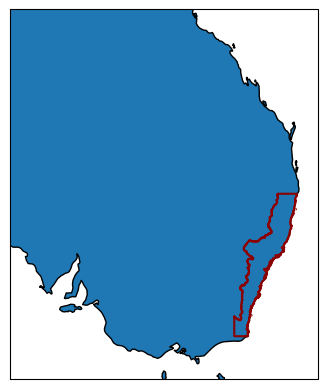

In [212]:
# # check region
# import cartopy, matplotlib.pyplot as plt

# fig, ax = plt.subplots(subplot_kw = {"projection" : cartopy.crs.PlateCarree(), "extent" : (xn,xx,yn,yx)})
# regionmask.defined_regions.natural_earth_v5_0_0.countries_50.to_geodataframe().set_index("names").loc[["Australia"]].plot(ax = ax)
# ax.coastlines()

# sf.boundary.plot(ax = ax, color = "darkred")

# Extract wider region

## CORDEX

In [21]:
fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/synda_Mariam/data/AUS-*/"
outpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/Australia-floods/cordex/"
fl = sorted(glob.glob(fpath+"*/*/*/*/*"))

In [22]:
for fnm in fl:
    
    new_fnm = outpath+fnm.split("/")[-1]
    print(fnm.split("/")[-1])
#     if os.path.exists(new_fnm): continue
        
    da = xr.open_dataset(fnm)
    
    if "lon" in da.data_vars:
        da = da.assign_coords(lon = da.lon, lat = da.lat)
    elif "longitude" in da.data_vars:
        da = da.assign_coords(lon = da.longitude, lat = da.latitude)
        
    if not "lon" in da.coords: continue
        
    da = convert_units_to(wrap_lon(da).pr, "mm/day")
        
    if "x" in da.dims:
        xdim,ydim = ["x","y"]
    else:
        xdim,ydim = ["rlon","rlat"]
        
    rm = np.logical_and(np.logical_and(da.lon >= xn, da.lon <= xx), np.logical_and(da.lat >= yn, da.lat <= yx))
    rm = rm.where(rm == 1, drop = True)
    
    da = da.sel({xdim : rm[xdim], ydim : rm[ydim]})
    
    da.to_netcdf(new_fnm)
    
clear_output(wait = False)
print("Done.")

Done.


# Daily time series & monthly spatial patterns

## HighresMIP

In [2]:
fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/Australia-floods/highresmip/"
fl = glob.glob(fpath+"*.nc")

for fnm in fl:
    
    mdl = fnm.split("_")[5]+"_"+fnm.split("_")[7]
    print(mdl)
    
    csv_fnm = "aus-floods_rx4day-amj_highresSST_"+mdl
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
    da = convert_units_to(xr.open_dataset(fnm).pr, "mm/day")
    
    # daily time series
    rm = regionmask.mask_geopandas(sf, da)
    ts = da.where(~np.isnan(rm)).mean(["lat", "lon"])
    ts.to_netcdf("data/pr-daily_highresSST_"+mdl+fnm[-21:])
    
    sp = da.sel(time = slice("1990","2020")).resample(time = "MS").sum().groupby("time.month").mean()
    sp.to_netcdf("data/pr-spatial_highresSST_"+mdl+".nc")
    
clear_output(wait = False)
print("Done.")

Done.


## CORDEX

In [3]:
outpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/Australia-floods/cordex/"

mlist = sorted(list(set(["_".join(re.sub("rcp85|historical", "*", fnm).split("_")[4:10]) for fnm in glob.glob(outpath+"*.nc")])))

In [4]:
gcm_lnames = {"MOHC-HadGEM2-ES" : "HadGEM2-ES",
              "MPI-M-MPI-ESM-LR" : "MPI-ESM-LR",
              "ICHEC-EC-EARTH" : "EC-EARTH",
              "NCC-NorESM1-M" : "NorESM1-M"}

rcm_lnames = {'CLMcom-HZG-CCLM5-0-15' : 'CCLM5-0-15', 
              'CLMcom-CCLM4-8-17-CLM3-5' : 'CCLM4-8-17-CLM3-5'}

In [5]:
for mdl in mlist:
    
    res,gcm,z,ens,rcm,v = mdl.split("_")
    
    gcm = gcm_lnames[gcm]
    rcm = rcm_lnames[rcm]
    
    new_fnm = "data/"+"_".join(["pr-daily",res,gcm,ens,rcm,v])
#     if len(glob.glob(re.sub("daily", "spatial", new_fnm)+"*")) > 0: continue
        
    print(res,gcm,ens,rcm)
    
    fl_hist = sorted(glob.glob(outpath+"*"+re.sub("\*", "historical", mdl)+"*.nc"))
    fl_rcp = sorted(glob.glob(outpath+"*"+re.sub("\*", "rcp85", mdl)+"*.nc"))
    
    new_fnm = new_fnm+fl_hist[0][-21:-11]+fl_rcp[-1][-11:]
    
    da_hist = xr.open_mfdataset(fl_hist).pr
    da_rcp = xr.open_mfdataset(fl_rcp).pr.assign_coords(rlon = da_hist.rlon)
    
    rm = regionmask.mask_geopandas(sf, da_hist.lon, da_hist.lat)
    
    if "x" in da_hist.dims:
        xdim,ydim = ["x","y"]
    else:
        xdim,ydim = ["rlon","rlat"]

    ts_hist = da_hist.where(~np.isnan(rm), drop = True).mean([xdim, ydim])
    ts_rcp = da_rcp.where(~np.isnan(rm), drop = True).mean([xdim, ydim])

    ts = xr.concat([ts_hist, ts_rcp], "time")
    ts.to_netcdf(new_fnm)
    
    sp = xr.concat([da_hist.sel(time = slice("1990","2020")), da_rcp.sel(time = slice("1990","2020"))], "time").groupby("time.month").mean()
    sp.to_netcdf(re.sub("daily", "spatial", new_fnm))
    
clear_output(wait = False)
print("Done.")

Done.


# Time series for trend fitting

## CORDEX & HighResMIP

In [67]:
framing = "AUS"
fl = glob.glob("data/pr-daily_"+framing+"*.nc")

In [68]:
for fnm in fl:
    
    framing = fnm.split("_")[1]
    if framing[:3] == "AUS": 
        framing = "CORDEX"
        mdl = "_".join(fnm.split("_")[1:5])
        csv_fnm = "aus-floods_rx4day"+suffix+"_"+mdl
    else:
        framing = "highresSST"
        mdl = "_".join(fnm.split("_")[2:4])
        csv_fnm = "aus-floods_rx4day"+suffix+"_highresSST_"+mdl
    print(csv_fnm)
    
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
        
    # create header lines for upload to Climate Explorer 
    str1 = "# contact :: "+framing+" rx4day"+suffix+" - New South Wales floods, c.barnes22@imperial.ac.uk"
    str2 = "# rx4day [mm/4day] - "+mname+" maxima of 4-day accumulated rainfall over coastal New South Wales at "+csv_fnm+".dat"
    head = "# year rx4day"
    
    ts = xr.open_dataset(fnm).pr
    ts_ann = ts.rolling(time = 4).sum().sel(time = ts.time.dt.month.isin(months)).resample(time = "AS-JUL", label = "right").max()
    df = ts_ann.assign_coords(time = ts_ann.time.dt.year).rename(time = "year").dropna("year", "all").to_dataframe()
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    df.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)
        
clear_output(wait = False)

## ACS

In [30]:
df = pd.read_csv("data/prAdjust_v1-r1-ACS-QME-AGCDv1-1960-2022_allRCMs_sf_newregion.csv", index_col = 0, parse_dates = [0])

for cnm in df.columns:
    
    mdl = "_".join(cnm.split("_")[:-1])
    print(mdl)
    df_c = df[[cnm]]
    
    csv_fnm = "aus-floods_rx4day"+suffix+"_ACS_"+mdl
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

    # create header lines for upload to Climate Explorer 
    str1 = "# contact :: ACS "+mdl+" rx4day"+suffix+" - New South Wales floods, c.barnes22@imperial.ac.uk"
    str2 = "# rx4day [mm/4day] - "+mname+" maxima of 4-day accumulated rainfall over coastal New South Wales at "+csv_fnm+".dat"
    head = "# year rx4day"

    df_ann = df_c.rolling(4).sum().loc[df_c.index.month.isin(months)].resample("AS-JUL", label = "right").max()
    df_ann.index = df_ann.index.year
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    df_ann.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)
    
clear_output(wait = False)

## GMST series

In [78]:
df = pd.read_csv("data/tas_globalmean_19cmip6.csv", header = [0,1], index_col = 0)
df.columns = ['_'.join(col).strip() for col in df.columns.values]
df = df - 273.15

df = df.rolling(4, center = True, min_periods = 1).mean()

In [80]:
for cnm in df.columns:
    
    print(cnm)
    df_c = df[[cnm]]
    
    csv_fnm = "aus-floods_gmst_ACS_"+cnm
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
        
    # create header lines for upload to Climate Explorer 
    str1 = "# contact :: ACS "+mdl+" 4-year smoothed GMST, c.barnes22@imperial.ac.uk"
    str2 = "# gmst [degC] - 4-day rolling mean (centred on 3rd year) of area-weighted mean surface temperature at "+csv_fnm+".dat"
    head = "# year gmst"
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    df_c.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)
    
clear_output(wait = False)

# Evaluation of seasonal cycle

In [15]:
# load obs
cpc = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/Australia-floods/obs/cpc_daily_ts_new.nc").precip
era5 = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/Australia-floods/obs/era5_daily_ts_new.nc").tp
mswep = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/Australia-floods/obs/mswep_daily_ts_new.nc").precip

# get seasonal cycles
cpc, era5, mswep = [ts.rolling(time = 15, center = True).mean().sel(time = slice("1990","2020")).groupby("time.dayofyear").mean() for ts in [cpc, era5, mswep]]

In [16]:
framing = "AUS"

fl = sorted(glob.glob("data/pr-daily_"+framing+"*.nc"))
n = len(fl)
nc = {"highresSST": 4, "AUS":3}[framing]
nr = int(np.ceil(n / nc))

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(len(days)) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(len(days)) if (days[i].day) == 15]

In [ ]:
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 4, nr * 3), dpi = 100, sharex = True)
plt.subplots_adjust(hspace = 0.3)

for i in range(n):
    ax = axs.flatten()[i]
    fnm = fl[i]
    
    ax.plot(cpc, label = "CPC")
    ax.plot(era5, label = "ERA5")
    ax.plot(mswep, label = "MSWEP")
    
    ts = xr.open_dataset(fnm).pr
    sc = ts.rolling(time = 15, center = True).mean().sel(time = slice("1990","2020")).groupby("time.dayofyear").mean()
    ax.plot(sc, color = "k", label = "Model")
    ax.set_title("\n".join(fnm.split("_")[2:4]))
    
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]
    
    ylim = ax.get_ylim()
    dstart = ts.sel(time = "2020-04-01").time.dt.dayofyear.values[0]
    dstop = ts.sel(time = "2020-07-01").time.dt.dayofyear.values[0]
    ax.add_patch(Rectangle((dstart, 0), dstop - dstart, ylim[1]+10, color = "gold", alpha = 0.3))
    ax.set_ylim(ylim)
    
leg = ax.get_legend_handles_labels()
axs[-1,-1].legend(*leg, loc = "upper left", frameon = False)
for i in range(n, nc*nr): axs.flatten()[i].set_axis_off()
    
if framing == "AUS":
    fr = "cordex"
else:
    fr = framing
    
plt.savefig("fig/mdl-eval_seasonal-cycle_"+fr+".png")

## Evaluation of spatial patterns

### Compute observed spatial patterns

In [120]:
# cpc = xr.open_mfdataset(sorted([fnm for fnm in glob.glob(fpath+"obs/cpc/*.nc") if int(fnm[-7:-3]) >= 1990 and int(fnm[-7:-3]) <= 2020])).precip.load().rename("pr")
# cpc_sp = cpc.sel(time = slice("1990","2020")).resample(time = "MS").sum().groupby("time.month").mean()
# cpc_sp = cpc_sp.where(cpc_sp > 0)
# cpc_sp.to_netcdf("data/pr-spatial_cpc.nc")

In [122]:
# era5 = xr.open_dataset(fpath+"obs/era5/era5_tp_daily_extended_133-155E_-40--18N_-999-lastyear_su.nc").tp.load().rename("pr")
# era5_sp = era5.sel(time = slice("1990","2020")).resample(time = "MS").sum().groupby("time.month").mean()
# era5_sp = era5_sp.where(era5_sp > 0)
# era5_sp.to_netcdf("data/pr-spatial_era5.nc")

In [ ]:
# mswep = xr.open_mfdataset(sorted([fnm for fnm in glob.glob(fpath+"obs/mswep/*.nc") if int(fnm[-10:-6]) >= 1990 and int(fnm[-10:-6]) <= 2020])).precip.load().rename("pr")
# mswep_sp = mswep.resample(time = "MS").sum().groupby("time.month").mean()
# mswep_sp = mswep_sp.where(mswep_sp > 0)
# mswep_sp.to_netcdf("data/pr-spatial_mswep.nc")

In [31]:
# load obs
cpc, era5, mswep = [xr.open_dataset("data/pr-spatial_"+ds_nm+".nc").pr.sel(month = months).mean("month") for ds_nm in ["cpc", "era5", "mswep"]]

### HighresSST

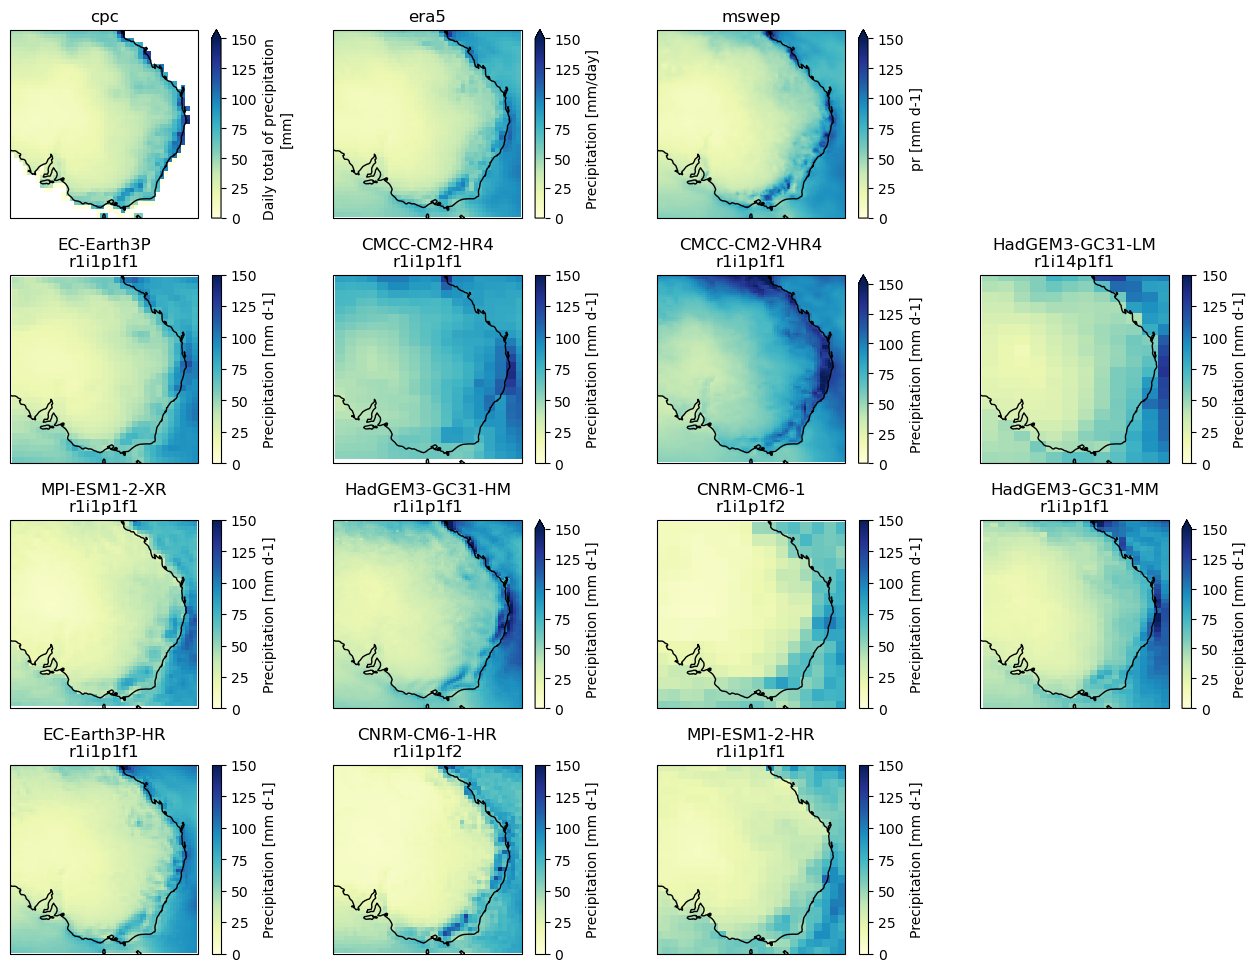

In [32]:
fl = glob.glob("data/pr-spatial_highresSST_*.nc")
n = len(fl)
nc = 4
nr = int(np.ceil(n / nc)) + 1

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 4, nr * 3), dpi = 100, sharex = True, 
                        subplot_kw = {"projection" : mapproj, "extent" : (xn,xx,yn,yx)})
plt.subplots_adjust(hspace = 0.3)
plot_kwargs = {"cmap" : "YlGnBu", "vmin" : 0, "vmax" : 150}

# observed spatial patterns
for i in range(3, nc): axs[0,i].set_axis_off()
for i in range(3):
    ax = axs[0,i]
    ds_nm = ["cpc", "era5", "mswep"][i]
    ds = eval(ds_nm)
    
    ds.plot(ax = ax, **plot_kwargs)
    ax.set_title(ds_nm)
    ax.coastlines()

# models
for i in range(n):
    ax = axs[1:,:].flatten()[i]
    fnm = fl[i]
    
    ds = xr.open_dataset(fnm).pr.sel(month = months).mean("month")
    ds.plot(ax = ax, **plot_kwargs)
    ax.set_title("\n".join(fnm[:-3].split("_")[2:]))
    ax.coastlines()
    
for i in range(n+nc, nc*nr): axs.flatten()[i].set_axis_off()
    
plt.savefig("fig/mdl-eval_spatial-pattern_pr"+suffix+"_highresSST.png")

### CORDEX

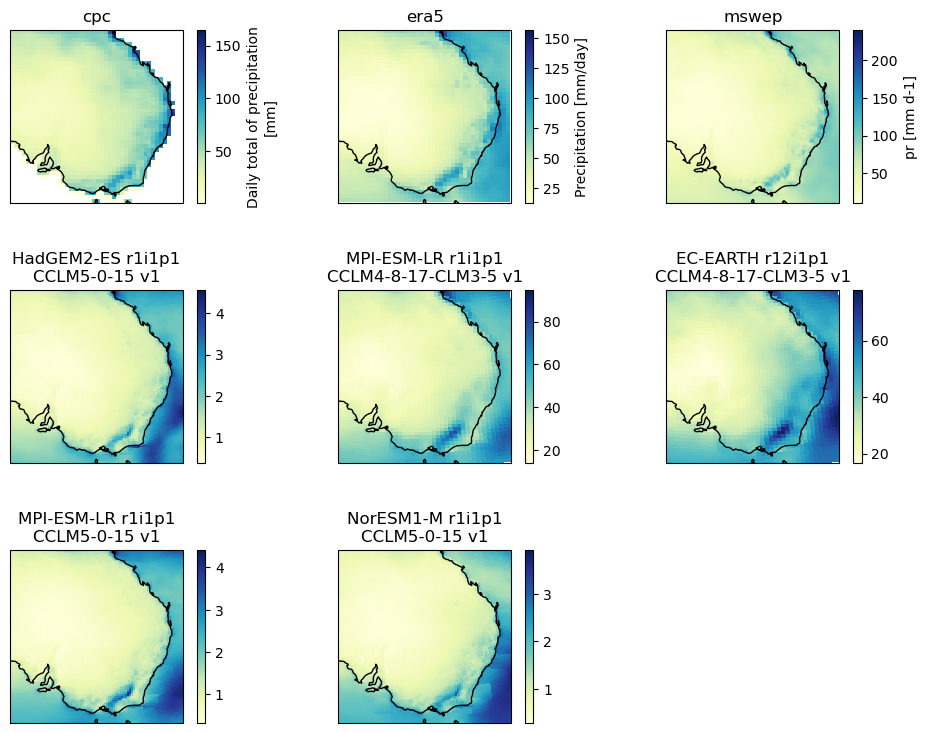

In [33]:
fl = glob.glob("data/pr-spatial_AUS*.nc")
n = len(fl)
nc = 3
nr = int(np.ceil(n / nc)) + 1

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 4, nr * 3), dpi = 100, sharex = True, 
                        subplot_kw = {"projection" : mapproj, "extent" : (xn,xx,yn,yx)})
plt.subplots_adjust(hspace = 0.5)
plot_kwargs = {"cmap" : "YlGnBu"}

# observed spatial patterns
for i in range(3, nc): axs[0,i].set_axis_off()
for i in range(3):
    ax = axs[0,i]
    ds_nm = ["cpc", "era5", "mswep"][i]
    ds = eval(ds_nm)
        
    ds.plot(ax = ax, **plot_kwargs)
    ax.set_title(ds_nm)
    ax.coastlines()

# models
for i in range(n):
    ax = axs[1:,:].flatten()[i]
    fnm = fl[i]
    gcm,ens,rcm,v = fnm[:-3].split("_")[2:-1]
    
    ds = xr.open_dataset(fnm).pr.sel(month = months).mean("month")
    
    cbar = ax.pcolormesh(ds.lon, ds.lat, ds, **plot_kwargs)
    ax.set_title(gcm+" "+ens+"\n"+rcm+" "+v)
    ax.coastlines()
    plt.colorbar(cbar, ax = ax)
    
for i in range(n+nc, nc*nr): axs.flatten()[i].set_axis_off()
    
plt.savefig("fig/mdl-eval_spatial-pattern_pr"+suffix+"_cordex.png")

# Quick trend check

In [54]:
def scale(ts): return (ts - ts.mean()) / ts.std()

In [46]:
z = [xr.open_dataset(fnm).pr.rename(fnm.split("_")[-3]) for fnm in sorted(glob.glob("data/pr-daily_highresSST*"))]
highres = merge_byindex([da.rolling(time = 4).sum().sel(time = da.time.dt.month.isin([4,5,6])).resample(time = "AS-JUL", label = "right").max().convert_calendar("standard", align_on = "date").to_dataframe() for da in z])
highres.index = highres.index.year

fig, ax = plt.subplots(dpi = 100)
for cnm in highres.columns:
    ax.plot(highres.index.values, np.poly1d(np.polyfit(highres.index.values[~np.isnan(highres[cnm])], highres[cnm][~np.isnan(highres[cnm])], deg = 1))(highres.index.values), label = cnm)
#     ax.plot(highres.index.values[~np.isnan(highres[cnm])], lowess(highres[cnm][~np.isnan(highres[cnm])], highres.index.values[~np.isnan(highres[cnm])])[:,1], ls = "--")
fig.legend()

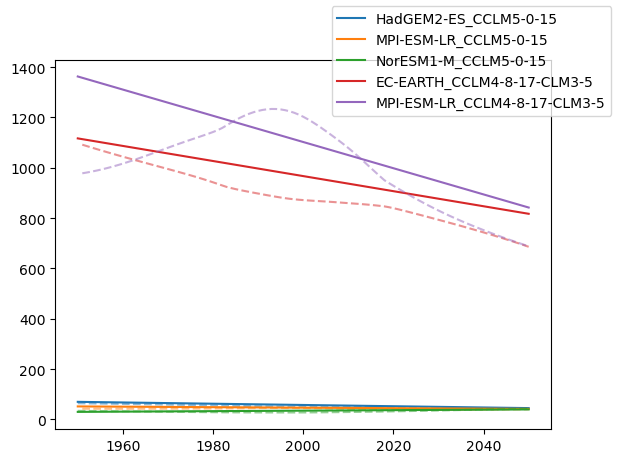

In [2]:
z = [xr.open_dataset(fnm).pr.rename(fnm.split("_")[2]+"_"+fnm.split("_")[4]) for fnm in sorted(glob.glob("data/pr-daily_AUS*"))]

cordex = merge_byindex([da.rolling(time = 4).sum().sel(time = da.time.dt.month.isin([4,5,6])).resample(time = "AS-JUL", label = "right").max().convert_calendar("standard", align_on = "date").to_dataframe() for da in z])
cordex.index = cordex.index.year

fig, ax = plt.subplots(dpi = 100)
for i in range(len(cordex.columns)):
    cnm = cordex.columns[i]
    col = matplotlib.colormaps['tab10'].colors[i]
    y = cordex[cnm].values
    x = cordex.index.values
    
    ax.plot(x, np.poly1d(np.polyfit(x[~np.isnan(y)], y[~np.isnan(y)], deg = 1))(x), label = cnm, color = col)
    ax.plot(x[~np.isnan(y)], lowess(y[~np.isnan(y)], x[~np.isnan(y)])[:,1], ls = "--", color = col, alpha = 0.5)
fig.legend()

# Check that all time series are correct

In [96]:
suffix = ""

<AxesSubplot: xlabel='year'>

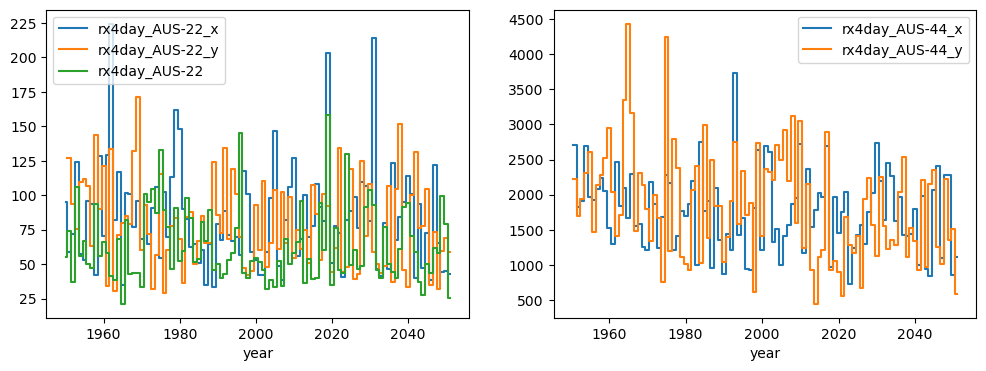

In [97]:
df = merge_byindex([pd.read_csv(fnm, comment = "#", sep = " ", header = None, names = ["year", "_".join(fnm.split("_")[1:3])], index_col = "year") for fnm in sorted(glob.glob("ts/*rx4day"+suffix+"_AUS*"))])

fig, axs = plt.subplots(ncols = 2, figsize = (12,4))

df.iloc[:,:3].plot(ax = axs[0], drawstyle = "steps-mid")
df.iloc[:,3:].plot(ax = axs[1], drawstyle = "steps-mid")

<AxesSubplot: xlabel='year'>

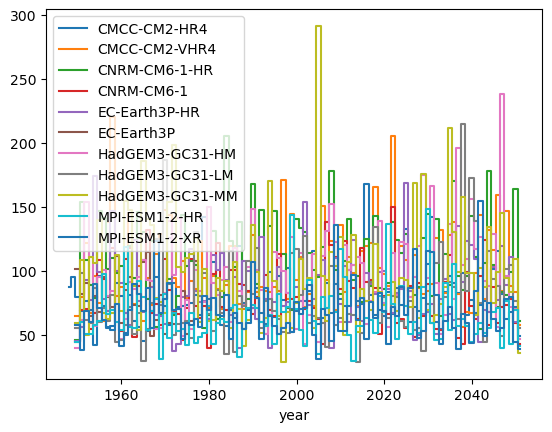

In [98]:
hrm = merge_byindex([pd.read_csv(fnm, comment = "#", sep = " ", header = None, names = ["year", fnm.split("_")[3]], index_col = "year") for fnm in sorted(glob.glob("ts/*rx4day"+suffix+"_highres*"))])
hrm.plot(drawstyle = "steps-mid")

<AxesSubplot: xlabel='year'>

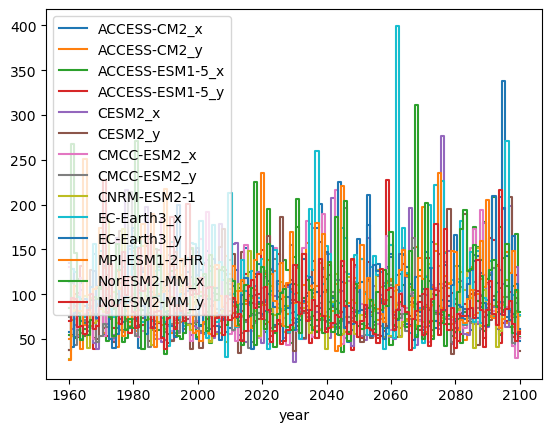

In [99]:
acs = merge_byindex([pd.read_csv(fnm, comment = "#", sep = " ", header = None, names = ["year", fnm.split("_")[3]], index_col = "year") for fnm in sorted(glob.glob("ts/*rx4day"+suffix+"_ACS*"))])
acs.plot(drawstyle = "steps-mid")